# ENS Snap

#### Date of submission: 9.10.22 
#### Date of initial creation: 8.10.22
#### Author: Daniel Müller

This python script collects data from ENS subgraph and calculates the expected date, when the grace period is over and the date, when premium is zero. The script then creates the payload for a Push Channel and executes a Javascript file, so subscribed users get the information about the upcoming Snap (register the domain) in their inbox / phone notification.

This benefits all ENS collectors that no longer have to check over and over again, if an ENS domain has been expended.

Ideal use: Run daily / servide side application.

#### Preparation: 
Make sure you are the sme same folder as your PushDemo.js file. Navigate their otherwise.

In [2]:
cd /Users/danielmueller/Documents/GitHub/DevconVI/push-sdk-quickstart

/Users/danielmueller/Documents/GitHub/DevconVI/push-sdk-quickstart


#### Check python version (min 3.10)

In [6]:
from platform import python_version
print(python_version())

3.10.6


## 1. Load ENS data from The Graph

#### Load required libraries

In [7]:
import pandas as pd
import numpy as np
from subgrounds.subgrounds import Subgrounds
sg = Subgrounds()

#### Define which subgraph to use

In [10]:
# Query domains of one owner
ENS_graph = sg.load_subgraph('https://api.thegraph.com/subgraphs/name/ensdomains/ens')

#### Define which holder's domains's information we like to gather

In [12]:
# Example: set to '0x4e05bc165652140654e0f07b7cb429e5e1b0ed92'
holders_address = '0x4e05bc165652140654e0f07b7cb429e5e1b0ed92'

# Limit graph data to holders address holdings
last10_ens = ENS_graph.Query.domains(
    first=10, 
    where=[ENS_graph.Domain.owner == holders_address
          ]
    )

# Query the fields. Check schema for reference.
owners_labelhashes_df = sg.query_df([
    last10_ens.labelhash,
    last10_ens.name,
    last10_ens.id, 
    last10_ens.owner,
    last10_ens.parent,
    last10_ens.parent
    ])

In [13]:
# Optional: Validate if domains_labelhash seem reasonable
list_owners_labelhashes = owners_labelhashes_df['domains_labelhash'].values
list_owners_labelhashes[0:5]

array(['0x38170cdc0a7ee1e2e099fcee358c1f0fdfa00549ddce5fe010332c634035f7d5',
       '0x1e4d4d9ca390aa9da9532079db777da88dd6f7b8eb7045aab6d9a5bbea7c0c55',
       '0xe478e50975aa987bca74399763989ad1ed28d6fab639cf61d19edd52873ac027',
       '0x93325e4140f6eca418ea7c3bad5b73bdc5bfa5c6ad79de637edc0e2bacaa8df9',
       '0xd46596ee2c3d3fa0d5ef2006097748bbf26d67e97e601c006ebe358c4327ebf7'],
      dtype=object)

#### Loop through all the list_owners_labelhashes (one for each ENS Domain) and query respective expiryDate

In [14]:
# create an Empty DataFrame object
output_df = pd.DataFrame()

for ENS_labelhash in list_owners_labelhashes:
    
    # now query expiry date
    labelhashes_ens = ENS_graph.Query.registrations(
        first=10, 
        #where=[ENS_graph.Registration.id == '0x38170cdc0a7ee1e2e099fcee358c1f0fdfa00549ddce5fe010332c634035f7d5'
        where=[ENS_graph.Registration.id == ENS_labelhash
              ]
                                                    )

    domains_expirations_df = sg.query_df([
        labelhashes_ens.expiryDate,
        labelhashes_ens.domain,
        labelhashes_ens.id,
        labelhashes_ens.registrationDate
        ])

    #print (domains_expirations_df)
    output_df = pd.concat([output_df, domains_expirations_df])
    #output_df.concat(domains_expirations_df)

In [15]:
# Optional: Check output
output_df

,registrations_expiryDate,registrations_domain_id,registrations_domain_name,registrations_domain_labelName,registrations_domain_labelhash,registrations_domain_parent_id,registrations_domain_subdomainCount,registrations_domain_resolvedAddress_id,registrations_domain_owner_id,registrations_domain_resolver_id,registrations_domain_ttl,registrations_domain_isMigrated,registrations_domain_createdAt,registrations_id,registrations_registrationDate
0,1686889896,0x26403195c8a40b0dc3115ac7d7c58c649fa789c0ccb2...,moringa.eth,moringa,0x38170cdc0a7ee1e2e099fcee358c1f0fdfa00549ddce...,0x93cdeb708b7545dc668eb9280176169d1c33cfd8ed6f...,0,0x4e05bc165652140654e0f07b7cb429e5e1b0ed92,0x4e05bc165652140654e0f07b7cb429e5e1b0ed92,0x4976fb03c32e5b8cfe2b6ccb31c09ba78ebaba41-0x2...,None,True,1580913635,0x38170cdc0a7ee1e2e099fcee358c1f0fdfa00549ddce...,1623775992
0,1656468025,0x37704683e9568cd5c0260e8d28fd9cf60be388ea92a5...,dots.eth,dots,0x1e4d4d9ca390aa9da9532079db777da88dd6f7b8eb70...,0x93cdeb708b7545dc668eb9280176169d1c33cfd8ed6f...,0,0x4e05bc165652140654e0f07b7cb429e5e1b0ed92,0x4e05bc165652140654e0f07b7cb429e5e1b0ed92,0x4976fb03c32e5b8cfe2b6ccb31c09ba78ebaba41-0x3...,None,True,1571774529,0x1e4d4d9ca390aa9da9532079db777da88dd6f7b8eb70...,1624911073
0,1672541565,0x3ce6ba878c6e225344e6fbfd13905988b4e13a996e42...,web3miami.eth,web3miami,0xe478e50975aa987bca74399763989ad1ed28d6fab639...,0x93cdeb708b7545dc668eb9280176169d1c33cfd8ed6f...,0,0x4e05bc165652140654e0f07b7cb429e5e1b0ed92,0x4e05bc165652140654e0f07b7cb429e5e1b0ed92,0x4976fb03c32e5b8cfe2b6ccb31c09ba78ebaba41-0x3...,None,True,1640984613,0xe478e50975aa987bca74399763989ad1ed28d6fab639...,1640984613
0,1661444720,0x4c4391f46b2c16315e76014a5579162c1e5fd93ed179...,nftmiami.eth,nftmiami,0x93325e4140f6eca418ea7c3bad5b73bdc5bfa5c6ad79...,0x93cdeb708b7545dc668eb9280176169d1c33cfd8ed6f...,0,0x4e05bc165652140654e0f07b7cb429e5e1b0ed92,0x4e05bc165652140654e0f07b7cb429e5e1b0ed92,0x4976fb03c32e5b8cfe2b6ccb31c09ba78ebaba41-0x4...,None,True,1629887768,0x93325e4140f6eca418ea7c3bad5b73bdc5bfa5c6ad79...,1629887768
0,1657413177,0x5932a74d6e015dc43dacba230da0ccbbcb016b3edc82...,nftdiva.eth,nftdiva,0xd46596ee2c3d3fa0d5ef2006097748bbf26d67e97e60...,0x93cdeb708b7545dc668eb9280176169d1c33cfd8ed6f...,0,0x4e05bc165652140654e0f07b7cb429e5e1b0ed92,0x4e05bc165652140654e0f07b7cb429e5e1b0ed92,0x4976fb03c32e5b8cfe2b6ccb31c09ba78ebaba41-0x5...,None,True,1625856225,0xd46596ee2c3d3fa0d5ef2006097748bbf26d67e97e60...,1625856225
0,1657061158,0x8559f623803478591ec00288581e79184c2f22ebfa8b...,barefoot.eth,barefoot,0x3b957a0fa2bbf56dd39077f3636205049e2b56f78b4b...,0x93cdeb708b7545dc668eb9280176169d1c33cfd8ed6f...,0,0x4e05bc165652140654e0f07b7cb429e5e1b0ed92,0x4e05bc165652140654e0f07b7cb429e5e1b0ed92,0x4976fb03c32e5b8cfe2b6ccb31c09ba78ebaba41-0x8...,None,True,1495570499,0x3b957a0fa2bbf56dd39077f3636205049e2b56f78b4b...,1625504206
0,1677030697,0xa3e2d4a7453a98602fc2bde4616ab60ef959e488982c...,darbar.eth,darbar,0x583d96cd33471c672c420bf3dfb9d7d4ff0107037ae3...,0x93cdeb708b7545dc668eb9280176169d1c33cfd8ed6f...,0,0x4e05bc165652140654e0f07b7cb429e5e1b0ed92,0x4e05bc165652140654e0f07b7cb429e5e1b0ed92,0x4976fb03c32e5b8cfe2b6ccb31c09ba78ebaba41-0xa...,None,True,1645473745,0x583d96cd33471c672c420bf3dfb9d7d4ff0107037ae3...,1645473745
0,1686777288,0xd3354287bcea02bad1686f7e3f094d221f49e0cec086...,jalak.eth,jalak,0xc48ece996c98262cdcbae6aae9b0ae374bd7549b9c30...,0x93cdeb708b7545dc668eb9280176169d1c33cfd8ed6f...,0,0x4e05bc165652140654e0f07b7cb429e5e1b0ed92,0x4e05bc165652140654e0f07b7cb429e5e1b0ed92,0x4976fb03c32e5b8cfe2b6ccb31c09ba78ebaba41-0xd...,None,True,1623663384,0xc48ece996c98262cdcbae6aae9b0ae374bd7549b9c30...,1623663384


# 2. Transform Graph Data / add Logic

#### Adding dates

In [30]:
# Import date class from datetime module
from datetime import date

# Adding dates
output_df['expiryDateHuman'] = pd.to_datetime(output_df['registrations_expiryDate'],unit='s')
# Returns the current local date
today = date.today()
output_df['current_timestamp'] = today

# CAVE: The grace period is defined by the ENS foundation to be 90 days
# CAVE: The grace period is defined by the ENS foundation to be 21 days. After this, this premium will be zero. 
#       The user may however define the grace period based on own preferences. In this demo we use 6 days as our grace period.
#       Impact: Domains which are 6 days after the grace period has started will cause a trigger notification.

import datetime
output_df['EoGrace'] = output_df['expiryDateHuman'] + datetime.timedelta(days=90)
output_df['EoGracePremium'] = output_df['expiryDateHuman'] + datetime.timedelta(days=90+6)

[Link to see premium example of domain](https://github.com/spyglassventures/ENS_Snap/blob/main/img/Premium.png)

#### Adding Trigger Logic

In [31]:
# Add comparison Logic
output_df['Trigger_Push'] = np.where((output_df['EoGracePremium'] <= output_df['current_timestamp']), 'Trigger_Push', 'Nothing_To_Do')

In [32]:
# Reorder columns and show DF
subset_output_df = output_df[['registrations_domain_name', 'expiryDateHuman', 'EoGrace', 'EoGracePremium', 'Trigger_Push']]
subset_output_df

,registrations_domain_name,expiryDateHuman,EoGrace,EoGracePremium,Trigger_Push
0,moringa.eth,2023-06-16 04:31:36,2023-09-14 04:31:36,2023-09-20 04:31:36,Nothing_To_Do
0,dots.eth,2022-06-29 02:00:25,2022-09-27 02:00:25,2022-10-03 02:00:25,Trigger_Push
0,web3miami.eth,2023-01-01 02:52:45,2023-04-01 02:52:45,2023-04-07 02:52:45,Nothing_To_Do
0,nftmiami.eth,2022-08-25 16:25:20,2022-11-23 16:25:20,2022-11-29 16:25:20,Nothing_To_Do
0,nftdiva.eth,2022-07-10 00:32:57,2022-10-08 00:32:57,2022-10-14 00:32:57,Nothing_To_Do
0,barefoot.eth,2022-07-05 22:45:58,2022-10-03 22:45:58,2022-10-09 22:45:58,Nothing_To_Do
0,darbar.eth,2023-02-22 01:51:37,2023-05-23 01:51:37,2023-05-29 01:51:37,Nothing_To_Do
0,jalak.eth,2023-06-14 21:14:48,2023-09-12 21:14:48,2023-09-18 21:14:48,Nothing_To_Do


We can see that the column EoGracePremium for dots.eth is 2022-10-02 02:00:25. This is smaller then our current date, 
so we trigger the notification. The same logic applies to barefoot.eth within the next days.

# 3. Trigger the notification via the Push protocol

In [33]:
# Prepare the dataset to only contains rows with Trigger set
trigger_df = subset_output_df[subset_output_df['Trigger_Push']=='Trigger_Push']
trigger_df

,registrations_domain_name,expiryDateHuman,EoGrace,EoGracePremium,Trigger_Push
0,dots.eth,2022-06-29 02:00:25,2022-09-27 02:00:25,2022-10-03 02:00:25,Trigger_Push


#### Create payload for JS file
This creates a file in the same directory.

In [34]:
# Create payload based on expired ENS Names
i = 0
for registrations_domain_name, row in trigger_df.iterrows():  # add EoGracePremium
    if i > len(trigger_df):
        break
    else:
        #f = open(str(i)+'.js', 'w') # use later for several push notification at the same time
        f = open('payload.js', 'w')
        f.write('// 👇️ named export')
        f.write('\n')
        f.write("export const title = 'ENS Snap Alert for "+ row[0]+ "';")
        f.write('\n')
        f.write('\n')
        f.write('// 👇️ named export')
        f.write('\n')
        f.write("export const body = 'The ENS domain "+ row[0]+ " is about to expire. Grab it!';")
        f.close()
        i+=1

#### Fire payload

In [35]:
# Trigger push notification with payload
!node PushDemo.js



API call :-->>  https://backend-staging.epns.io/apis/v1/payloads/ 

 {
  verificationProof: 'eip712v2:0x92564cc6fc0c11d25a2eac4922a76a29adb94fbcfa199f5accb0cd22b2f81d8c34fdeda959b9f212c6f1c87ecebdb41a8af028cc4fb3f8389116dee21aa5cdbb1c::uid::53561732-ef81-465a-86ad-633e14e38008',
  identity: '2+{"notification":{"title":"ENS Snap Alert for dots.eth","body":"The ENS domain dots.eth is about to expire. Grab it!"},"data":{"acta":"","aimg":"","amsg":"The ENS domain dots.eth is about to expire. Grab it!","asub":"ENS Snap Alert for dots.eth","type":"3"},"recipients":"eip155:5:0x1310D972e91252aF9B2e26426f0429c9dA8dF5b2"}',
  sender: 'eip155:5:0x1310D972e91252aF9B2e26426f0429c9dA8dF5b2',
  source: 'ETH_TEST_GOERLI',
  recipient: 'eip155:5:0x1310D972e91252aF9B2e26426f0429c9dA8dF5b2'
} 




API repsonse:  {
  status: 204,
  statusText: 'No Content',
  headers: {
    server: 'nginx',
    date: 'Sun, 09 Oct 2022 12:41:31 GMT',
    connection: 'close',
    'x-powered-by': 'Express',
    'access-con

### Your are done

### Optional: Verification
If you have a push notifcation set, you will receive an alert on your phone.

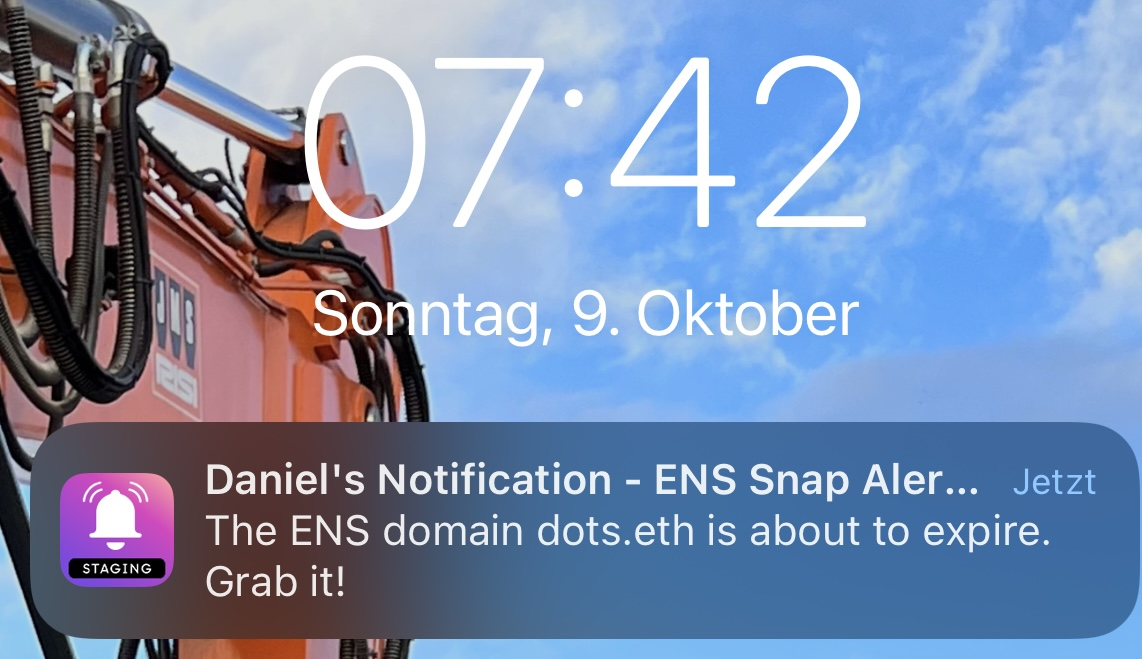

In [39]:
from IPython.display import Image
Image(filename='Notification.jpg') 